In [150]:
import os, sys
import pyphase
from pyphase import *
import numpy as np 
from PIL import Image
import numpy as np
from math import *
import matplotlib.pyplot as pyplot
import scipy.ndimage
from pyphase.config import *
from matplotlib.pyplot import pause
from scipy import interpolate
from scipy import ndimage 
from skimage.io import imread, imshow

/home/mfre190/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper
/home/mfre190/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:293: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  plugin_module = __import__('skimage.io._plugins.' + modname,


In [2]:
import matplotlib.pyplot as plt

In [8]:
x_data_dir = "../datasets/Ballies/1mm"
y_data_dir = "../datasets/Ballies/0mm"

In [9]:
for x_tif in sorted(os.listdir(x_data_dir))[:1]:
    x_data = np.array([np.array(Image.open(os.path.join(x_data_dir, x_tif)))])  
for y_tif in sorted(os.listdir(y_data_dir))[:1]: 
    y_data = np.array([np.array(Image.open(os.path.join(y_data_dir, y_tif)))])

In [138]:
class TIEHOM:
        
    def __init__(self, image=None, delta_beta=500, **kwargs):    
        self.lengthscale=10e-6
        self.delta_beta=delta_beta
        self.padding = 1
        self.nx=image.shape[0]
        self.ny=image.shape[1]
        self.pixel_size = 1e-6   
        self.sample_frequency = int(self.lengthscale/self.pixel_size)
        self.ND = 1
        self.distance = np.array(1e-2)
        self.nfx = self.padding*self.nx 
        self.nfy = self.padding*self.ny  
        self.energy = 100 #KeV 
        self.Lambda = 12.4e-10 / self.energy
        self.Fresnel_number = self.Lambda * self.distance / (self.lengthscale**2)  
        self.fx, self.fy = self.frequency_variable(self.nfx, self.nfy, self.sample_frequency) 
        
    def frequency_variable(self, nfx, nfy, sample_frequency):
        
        if type(sample_frequency) == int:
            sample_frequency = np.array([sample_frequency, sample_frequency]) #TODO: refactor
        
        x=0
        x=np.append(x, np.linspace(sample_frequency[0]/nfx, sample_frequency[0]/2, nfx//2))
        x=np.append(x, np.linspace(-sample_frequency[0]/2+sample_frequency[0]/nfx, -sample_frequency[0]/nfx, int(nfx//2-1+(np.ceil(nfx/2)-nfx//2))))
        
        y=0
        y=np.append(y, np.linspace(sample_frequency[1]/nfy, sample_frequency[1]/2, nfy//2))
        y=np.append(y, np.linspace(-sample_frequency[1]/2+sample_frequency[1]/nfy, -sample_frequency[1]/nfy, int(nfy//2-1+(np.ceil(nfy/2)-nfy//2))))
        return np.meshgrid(x, y) 
    
    def _algorithm(self, image):
        """Reconstruct one image or a set of images using TIEHOM."""

        FID=np.fft.fft2(image) 

        TIEHOM_factor = 1 + self.Fresnel_number * np.pi * self.delta_beta * ((self.fx ** 2) + (self.fy ** 2))
        
        phase = 1/2 * self.delta_beta * np.log(np.real(np.fft.ifft2(FID / TIEHOM_factor)))
        
        attenuation = -1/(self.delta_beta) * phase

        return phase, attenuation


In [160]:
x_data[0] = imread(('../datasets/Ballies/1mm/32p1r174.tif'), as_gray=True)[:,:] 
y_data[0] = imread(('../datasets/Ballies/0mm/32p0r174.tif'), as_gray=True)[:,:] 
phase_array, attenuation_array = TIEHOM(image=np.array(x_data[0]))._algorithm(image=np.array(x_data[0]))

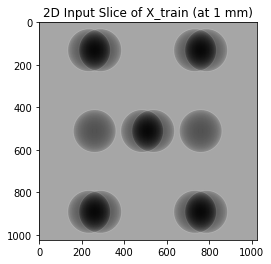

In [161]:
plt.imshow(x_data[0], cmap="gray");
plt.title('2D Input Slice of X_train (at 1 mm)');
plt.show();

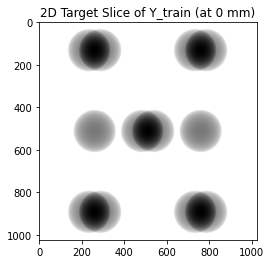

In [162]:
plt.imshow(y_data[0], cmap="gray") 
plt.title('2D Target Slice of Y_train (at 0 mm)');
plt.show();

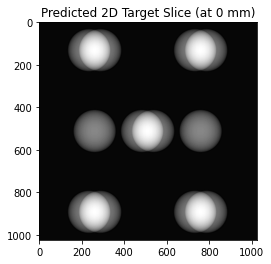

In [163]:
plt.imshow(attenuation_array, cmap="gray")
plt.title('Predicted 2D Target Slice (at 0 mm)');
plt.show();

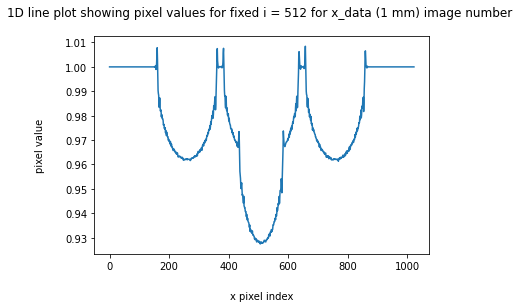

In [164]:
line = x_data[0][512, :]
plt.plot(np.squeeze(line))
plt.title('1D line plot showing pixel values for fixed i = 512 for x_data (1 mm) image number ', pad=20)
plt.xlabel('x pixel index', labelpad=20)
plt.ylabel('pixel value', labelpad=20)
plt.show()

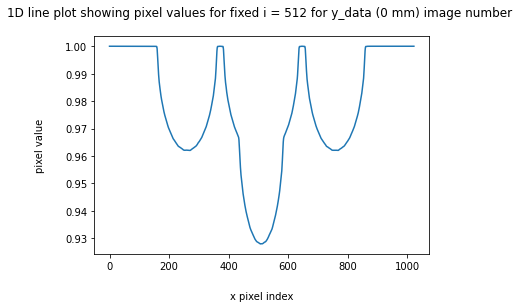

In [165]:
line = y_data[0][512, :]
plt.plot(np.squeeze(line))
plt.title('1D line plot showing pixel values for fixed i = 512 for y_data (0 mm) image number ', pad=20)
plt.xlabel('x pixel index', labelpad=20)
plt.ylabel('pixel value', labelpad=20)
plt.show()

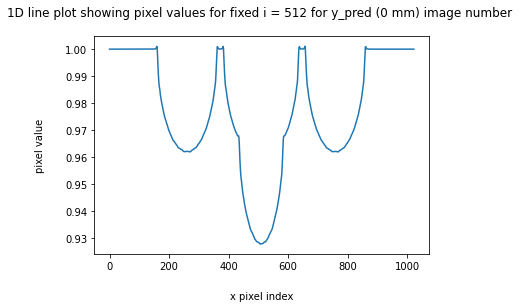

In [166]:
line = np.exp(-2*attenuation_array[512, :])
plt.plot(np.squeeze(line))
plt.title('1D line plot showing pixel values for fixed i = 512 for y_pred (0 mm) image number ', pad=20)
plt.xlabel('x pixel index', labelpad=20)
plt.ylabel('pixel value', labelpad=20)
plt.show()